In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command
%pwd

/content/gdrive/My Drive/Kaggle


'/content/gdrive/My Drive/Kaggle'

In [4]:
!kaggle datasets download -d ignaciorlando/ussimandsegm

ussimandsegm.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#check pwd to be '/content/'
%cd ..
%cd ..
%cd ..
%pwd

/content/gdrive/My Drive
/content/gdrive
/content


'/content'

In [6]:
from shutil import copy

copy('/content/gdrive/MyDrive/Kaggle/ussimandsegm.zip', '/content/')
drive.flush_and_unmount()

In [7]:
#unzipping the data
! unzip ussimandsegm.zip

Archive:  ussimandsegm.zip
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-1.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-10.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-11.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-12.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-13.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-14.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-15.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-16.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-17.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-18.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-19.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-2.png  
  inflating: abdominal_US/abdominal_US/AUS/annotations/test/ct1-20.png  
  inflating: abdominal_US/

926 926
(449,)
[  0  76 255]


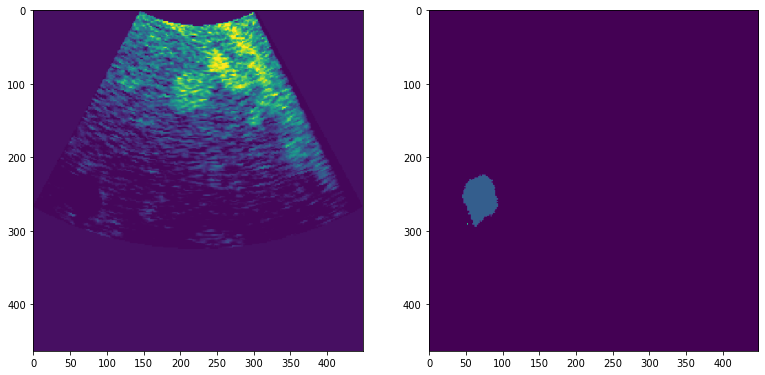

In [8]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv 

train_image_names = []
train_mask_names = []

for root, _, files in os.walk('/content/abdominal_US/abdominal_US/AUS/images/train'):
    for i in files:
        img_path = os.path.join('/content/abdominal_US/abdominal_US/AUS/images/train', i)
        mask_path = os.path.join('/content/abdominal_US/abdominal_US/AUS/annotations/train', i)
        train_image_names.append(img_path)
        train_mask_names.append(mask_path)

for root, _, files in os.walk('/content/abdominal_US/abdominal_US/AUS/images/test'):
    for i in files:
        img_path = os.path.join('/content/abdominal_US/abdominal_US/AUS/images/test', i)
        mask_path = os.path.join('/content/abdominal_US/abdominal_US/AUS/annotations/test', i)
        train_image_names.append(img_path)
        train_mask_names.append(mask_path)

n=13
fig, axs = plt.subplots(1,2, figsize=[13,15])
image = cv.imread(train_image_names[n], 0)
#image = ImageOps.grayscale(image)
#image = np.array(image)
mask = cv.imread(train_mask_names[n])
#mask = ImageOps.grayscale(mask)
#mask = np.array(mask)
mask = np.where(mask==(10), (0), mask)
mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
axs[0].imshow(image)
axs[1].imshow(mask)
print(len(train_mask_names), len(train_image_names))
print(mask[0].shape)
print(np.unique(mask))

In [9]:
import pandas as pd

images = []
masks = []
img_height = 256
img_width = 256

for i in train_image_names:
    image = cv.imread(i)
    image = cv.resize(image, (img_height, img_width), interpolation = cv.INTER_AREA)
    image = image/255.0
    images.append(image)

for i in train_mask_names:
    mask = cv.imread(i)
    mask = np.where(mask==(10), (0), mask)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    mask = cv.resize(mask, (img_height, img_width), interpolation=cv.INTER_NEAREST)
    if 2 in np.unique(mask):
        print("Error") #sanity
    masks.append(mask)

images = np.array(images)
images = np.expand_dims(images, axis=3)
images = np.reshape(images, (-1, 256, 256, 3))
masks = np.array(masks)

In [10]:
print(np.unique(masks))
print(images.shape)

[  0  29  41  76 105 150 179 226 255]
(926, 256, 256, 3)


In [11]:
%tensorflow_version 2.x

import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout, BatchNormalization, Activation, Lambda
from tensorflow.keras.layers import Cropping2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2.7.0


In [12]:
def unet_model(no_classes, img_height, img_width):
    input = Input((img_height, img_width, 3), name='images')
    s = input

    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPool2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPool2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPool2D((2,2))(c3)    

    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPool2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(c5)
    c5 = BatchNormalization()(c5)
    p5 = MaxPool2D((2,2))(c5)

    c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(p5)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(c9)
    c9 = BatchNormalization()(c9)

    u10 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(32, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(u10)
    c10 = BatchNormalization()(c10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(32, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(c10)
    c10 = BatchNormalization()(c10)

    u11 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c10)
    u11 = concatenate([u11, c1])
    c11 = Conv2D(16, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(u11)
    c11 = BatchNormalization()(c11)
    c11 = Dropout(0.1)(c11)
    c11 = Conv2D(16, (3,3), activation='relu', kernel_initializer = 'he_normal',padding='same')(c11)
    c11 = BatchNormalization()(c11)

    output = Conv2D(no_classes, (1,1), activation="softmax", name='masks')(c11)

    model = Model(inputs=[input], outputs=[output])
    
    return model

In [13]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.1)

In [14]:
print(train_images.shape, train_masks.shape)

(833, 256, 256, 3) (833, 256, 256)


In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def data_generator(images, masks, batch_size=8):
    while True:
        i=0
        while i<len(images)//batch_size:
            image_batch=np.zeros((batch_size, img_height, img_width, 3))
            mask_batch=np.zeros((batch_size, img_height, img_width))

            for j in range(batch_size):
                image, mask = images[i*j+j], masks[i*j+j]
                image_batch[j] = image
                mask_batch[j] = mask
                labelencoder = LabelEncoder()
                n, h, w = mask_batch.shape
                mask_batch_reshaped = mask_batch.reshape(-1, 1)
                mask_batch_reshaped_encoded = labelencoder.fit_transform(mask_batch_reshaped)
                mask_batch_encoded = mask_batch_reshaped_encoded.reshape(n, h, w)
                mask_batch_encoded = np.expand_dims(mask_batch_encoded, axis=3)
                mask_batch_cat = to_categorical(mask_batch_encoded, num_classes=9)
            i+=1
            yield {'images':image_batch}, {'masks':mask_batch_cat}

In [16]:
n, h, w = test_masks.shape
labelencoder = LabelEncoder()
test_masks_reshaped = test_masks.reshape(-1, 1)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
test_masks_encoded = test_masks_reshaped_encoded.reshape(n, h, w)
test_masks_encoded = np.expand_dims(test_masks_encoded, axis=3)

np.unique(test_masks_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [17]:
def get_model():
    return unet_model(no_classes=9, img_height=img_height, img_width=img_width)

In [18]:
def jaccard_loss(y_true, y_pred, smooth=1):

    intersection = tf.reduce_sum( y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)
    return (1 - jac) * smooth

In [19]:
model=get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[jaccard_loss])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images (InputLayer)            [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['images[0][0]']                 
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
callbacks=[tf.keras.callbacks.ModelCheckpoint(
    '/content/ultrasound_model.h5',
    monitor="val_jaccard_loss", save_best_only=True)]

In [22]:
history = model.fit(data_generator(train_images, train_masks, 8),
                    steps_per_epoch = len(train_images)//8,
                    validation_data=data_generator(test_images, test_masks, 8),
                    validation_steps = len(test_images)//8,
                    epochs=250, 
                    callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/250
104/104 [==============================] - 58s 410ms/step - loss: 1.5009 - jaccard_loss: 0.4946 - val_loss: 1680.9460 - val_jaccard_loss: 0.5617
Epoch 2/250
104/104 [==============================] - 42s 406ms/step - loss: 0.6934 - jaccard_loss: 0.2873 - val_loss: 66.6520 - val_jaccard_loss: 0.4024
Epoch 3/250
104/104 [==============================] - 41s 398ms/step - loss: 0.4715 - jaccard_loss: 0.1834 - val_loss: 58.7349 - val_jaccard_loss: 0.5328
Epoch 4/250
104/104 [==============================] - 43s 410ms/step - loss: 0.3870 - jaccard_loss: 0.1423 - val_loss: 36.8386 - val_jaccard_loss: 0.5170
Epoch 5/250
104/104 [==============================] - 42s 402ms/step - loss: 0.3385 - jaccard_loss: 0.1203 - val_loss: 4.3968 - val_jaccard_loss: 0.2009
Epoch 6/250
104/104 [==============================] - 41s 399ms/step - loss: 0.3068 - jaccard_loss: 0.1061 - val_loss: 1.6684 - val_jaccard_loss: 0.1739
Epoch 7/250
104/104 [==============================] - 41s 397ms/step 

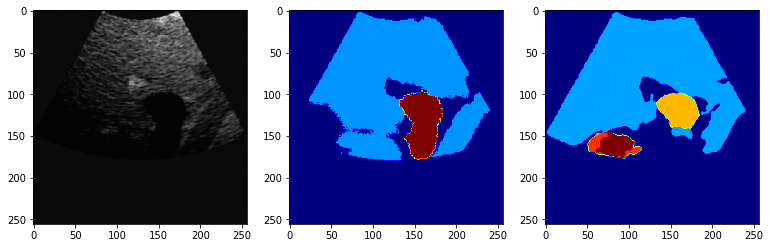

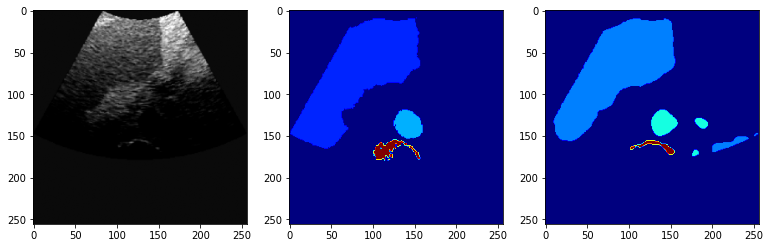

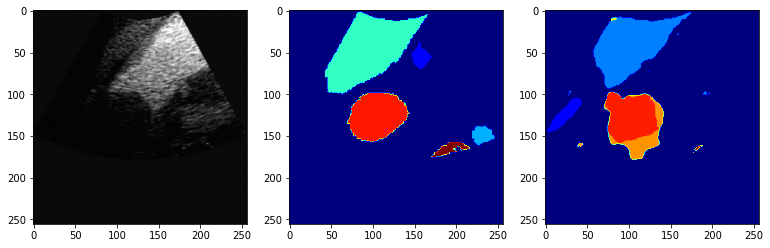

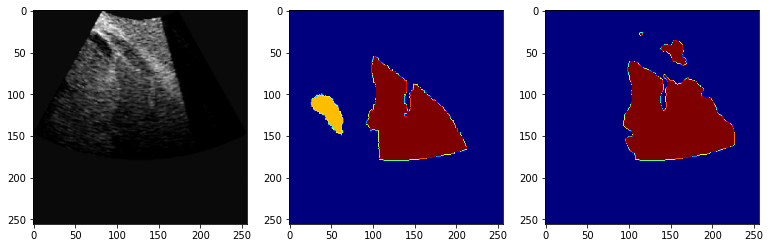

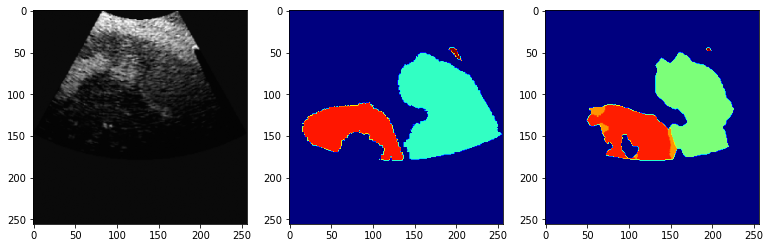

In [23]:
l = [0, 5, 10, 15, 20]
for n in l:
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    image = test_images[n]
    image = cv.resize(image, (256,256), interpolation=cv.INTER_AREA)
    #image = image/255.0
    image_input = np.expand_dims(image, axis=0)
    mask = test_masks[n]
    '''mask = np.where(mask==(10), (0), mask)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    mask = cv.resize(mask, (256, 256), interpolation = cv.INTER_NEAREST)'''
    prediction = model.predict(image_input)
    #print(prediction.shape)
    prediction_img = np.argmax(prediction[:,:,:,0:], axis=3)[0]
    axs[0].imshow(image)
    axs[1].imshow(mask, cmap='jet')
    axs[2].imshow(prediction_img, cmap='jet')
    plt.show()
#print(prediction_img)